## Context

ABC Supermarket is planning for the year-end sale - they want to launch a new offer i.e. gold membership for only \\$499 that is of \\$999 on normal days (that gives 20% discount on all purchases) only for existing customers, for that they need to do a campaign through phone calls - the best way to reduce the cost of the campaign is to make a predictive model to classify customers who might purchase the offer, using the data they gathered during last year's campaign.

We will build a model for classifying whether customers will reply with a positive
response or not.

## Import Statements

In [378]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [379]:
df = pd.read_excel("marketing_data.xlsx")

In [380]:
df.shape

(2240, 22)

## Column Definitions
- Response (target) - 1 if customer accepted the offer in the last campaign, 0
otherwise
- Complain - 1 if a customer complained in the last 2 years
- DtCustomer - date of customer’s enrolment with the company
- Education - customer’s level of education
- Marital - customer’s marital status
- Kidhome - number of small children in customer’s household
- Teenhome - number of teenagers in customer’s household
- Income - customer’s yearly household income
- MntFishProducts - the amount spent on fish products in the last 2 years
- MntMeatProducts - the amount spent on meat products in the last 2 years
- MntFruits - the amount spent on fruits products in the last 2 years
- MntSweetProducts - amount spent on sweet products in the last 2 years
- MntWines - the amount spent on wine products in the last 2 years
- MntGoldProds - the amount spent on gold products in the last 2 years
- NumDealsPurchases - number of purchases made with discount
- NumCatalogPurchases - number of purchases made using catalog
- NumStorePurchases - number of purchases made directly in stores
- NumWebPurchases - number of purchases made through the company’s web site
- NumWebVisitsMonth - number of visits to company’s web site in the last month
- Recency - number of days since the last purchase
- ID - unique customer-id
- Year_Birth - customer's year of birth

## Data Profiling

In [381]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Response                 int64
Complain                 int64
dtype: object

In [382]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
dtype: int64

In [383]:
df['Income'] = df['Income'].fillna(0)

### Data Preprocesssing

In [384]:
# Extracting Year from customer's date of enrolment

from datetime import datetime

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%m/%d/%y')
df['Dt_Customer'] = df['Dt_Customer'].dt.year

df['Dt_Customer']

0       2014
1       2014
2       2014
3       2014
4       2014
        ... 
2235    2013
2236    2013
2237    2012
2238    2012
2239    2012
Name: Dt_Customer, Length: 2240, dtype: int32

In [385]:
df['Year_Birth'].unique()

array([1970, 1961, 1958, 1967, 1989, 1954, 1947, 1979, 1959, 1981, 1969,
       1977, 1960, 1966, 1976, 1965, 1956, 1975, 1971, 1986, 1972, 1974,
       1990, 1987, 1984, 1968, 1955, 1983, 1973, 1978, 1952, 1962, 1964,
       1982, 1963, 1957, 1980, 1945, 1949, 1948, 1953, 1946, 1985, 1992,
       1944, 1951, 1988, 1950, 1994, 1993, 1991, 1893, 1996, 1995, 1899,
       1943, 1941, 1940, 1900], dtype=int64)

In [386]:
# Removing Customer Records with Year_Birth earlier than 1940

def remove_centennial_cust(df):
    return df[df['Year_Birth']>=1940]

df = remove_centennial_cust(df)

df['Year_Birth'].unique()

array([1970, 1961, 1958, 1967, 1989, 1954, 1947, 1979, 1959, 1981, 1969,
       1977, 1960, 1966, 1976, 1965, 1956, 1975, 1971, 1986, 1972, 1974,
       1990, 1987, 1984, 1968, 1955, 1983, 1973, 1978, 1952, 1962, 1964,
       1982, 1963, 1957, 1980, 1945, 1949, 1948, 1953, 1946, 1985, 1992,
       1944, 1951, 1988, 1950, 1994, 1993, 1991, 1996, 1995, 1943, 1941,
       1940], dtype=int64)

In [387]:
df['NumStorePurchases'].unique()

array([ 6,  7,  5,  2,  3,  9, 10,  0,  8,  4, 13, 12,  1, 11],
      dtype=int64)

## Initial Exploratory Data Analysis

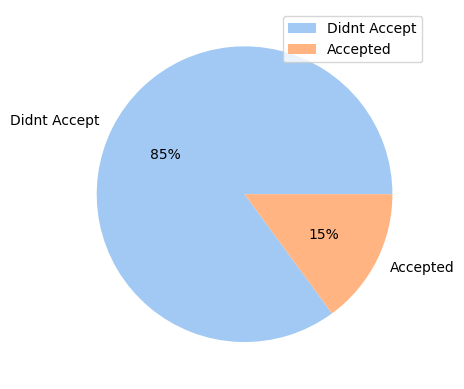

In [388]:
colors = sns.color_palette('pastel')[0:len(df['Response'].value_counts())]

#create pie chart
plt.pie(df['Response'].value_counts(), labels=['Didnt Accept', 'Accepted'], colors = colors, autopct='%.0f%%')
plt.legend()
plt.show()

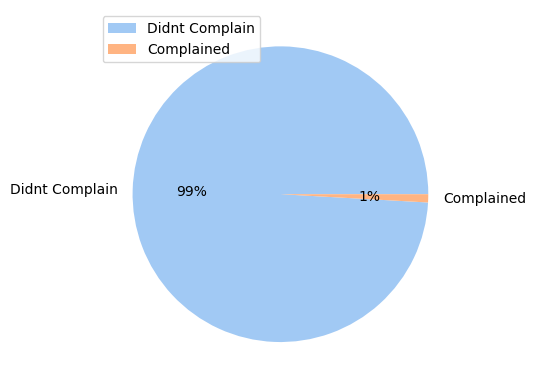

In [389]:
colors = sns.color_palette('pastel')[0:len(df['Complain'].value_counts())]

#create pie chart
plt.pie(df['Complain'].value_counts(), labels=['Didnt Complain', 'Complained'], colors = colors, autopct='%.0f%%')
plt.legend()
plt.show()

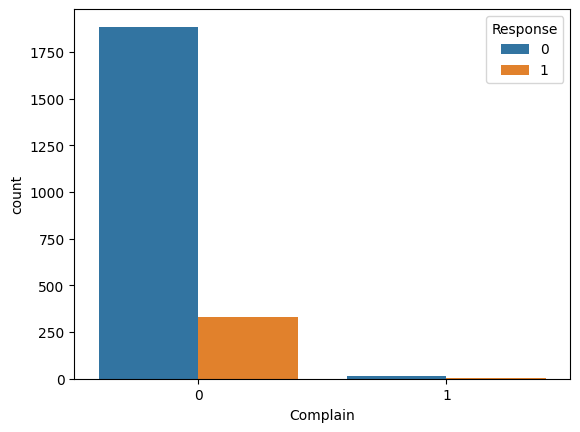

In [390]:
sns.barplot(x = 'Complain', y='count', hue = 'Response',data=df[['Complain', 'Response']].value_counts().reset_index())
    
plt.show()

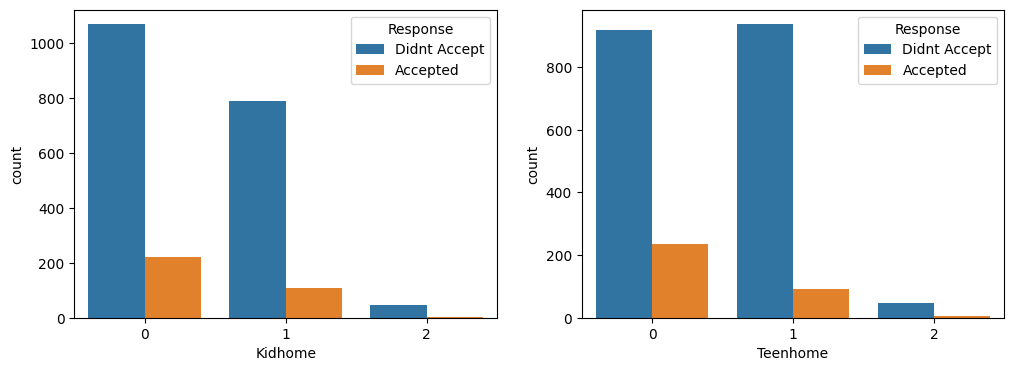

In [391]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

for i, ax, col in zip(range(2), axes.flat, ['Kidhome', 'Teenhome']):
    tmp = df[[col, 'Response']].value_counts().to_frame().reset_index()
    tmp['Response'] = tmp['Response'].replace({0: 'Didnt Accept', 1: 'Accepted'})

    sns.barplot(x = col, y='count', 
                   hue = 'Response',data=tmp, ax=ax)
    
plt.show()

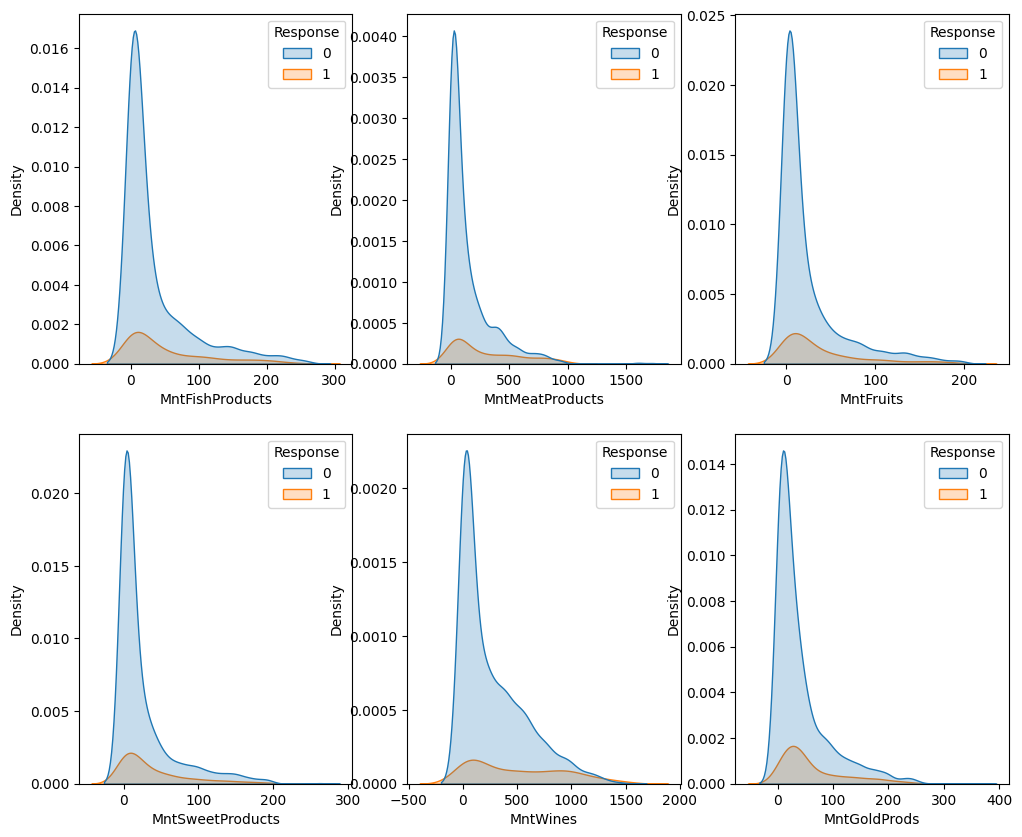

In [392]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 10))

for i, ax, col in zip(range(6), axes.flat, ['MntFishProducts', 'MntMeatProducts', 'MntFruits', 'MntSweetProducts', 'MntWines', 'MntGoldProds']):
    sns.kdeplot(df, x=col, hue='Response', fill=True, ax=ax)
    
plt.show()

## Baseline Modelling

In [393]:
X = df.drop('Response', axis=1).iloc[:,1:][['MntFishProducts', 'MntMeatProducts', 'MntFruits'
                                            , 'MntSweetProducts', 'MntWines', 'MntGoldProds', 'Dt_Customer']]
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [394]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [395]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [396]:
clf = LogisticRegression().fit(X_train, y_train)
preds = clf.predict(scaler.transform(X_test))

In [397]:
acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
auc = roc_auc_score(y_test, preds)

In [398]:
print("Accuracy: %.4f" % acc)
print("Precision: %.4f" % prec)
print("Recall: %.4f" % rec)
print("F1: %.4f" % f1)
print("AUC: %.4f" % auc)

Accuracy: 0.8571
Precision: 1.0000
Recall: 0.0400
F1: 0.0769
AUC: 0.5200


### Result Matrix and Graphs

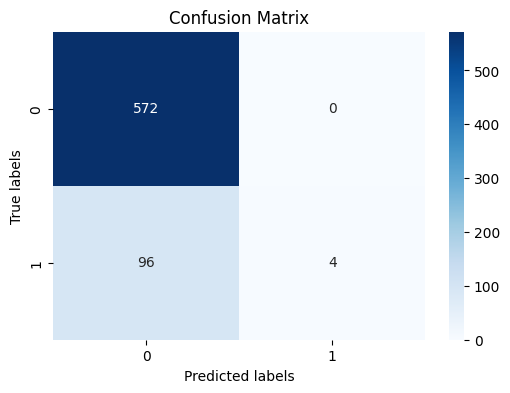

In [399]:
conf_mat = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

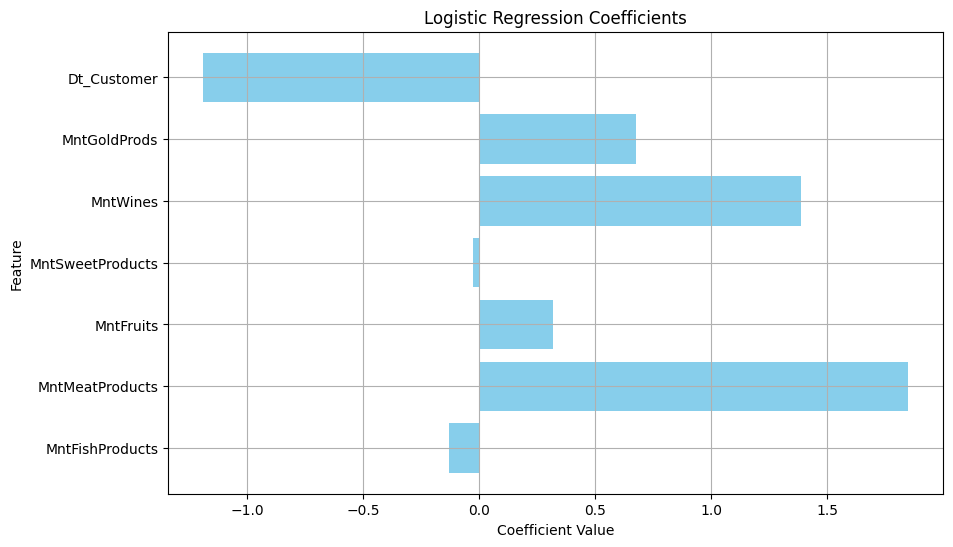

In [400]:
## Feature Importance
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(feature_names)), clf.coef_[0], color='skyblue')
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.grid(True)
plt.show()